EDA Visualization for multivariate regression problem

The idea of this jupyter book was to go deeper into exploratory data analysis and visualize relationships before the data is changed and the regression model is created.
Documentation: https://seaborn.pydata.org/

Import libraries

In [3]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Data display customization
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

data = pd.read_csv(r"C:\Users\dariu\Documents\Code Project\Regression\Insurance\datasets_insurance.csv")
data.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


The idea here is to try to identify correlation between the different variables before creating the actual machine learning model. Since the number of features is small, it is easy to plot some relation using seaborn & matplotlib.

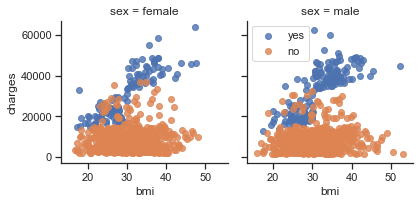

In [5]:
sns.set(style = 'ticks')

#smoke given male, female
g0 = sns.FacetGrid(data, col = 'sex', hue = 'smoker')
g0.map(sns.regplot, 'bmi', 'charges', fit_reg = False, x_jitter = .1)
plt.legend()

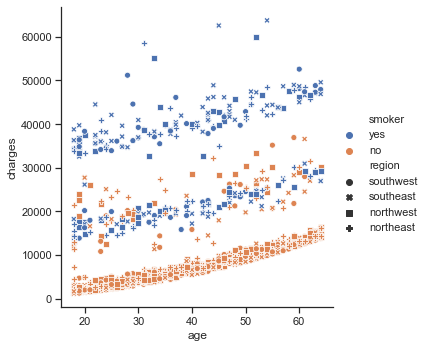

In [6]:
g1 = sns.relplot(x = 'age', y = 'charges', hue = 'smoker', style = 'region', data = data)
#price gets higher for smokers
#need to check with the guys that retrieve the data if they didn't categorize into certain prices (gaps in charges)

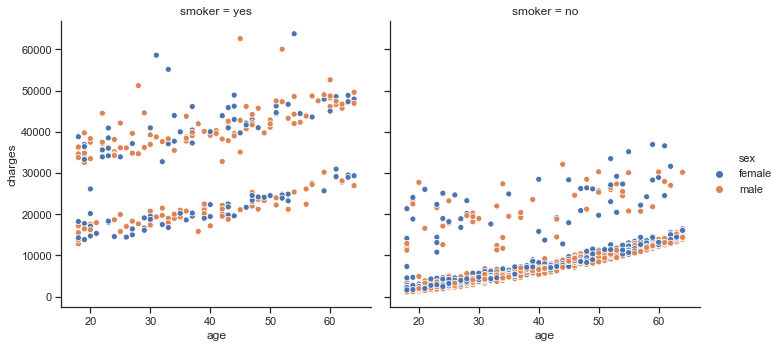

In [7]:
g2 = sns.relplot(x = 'age', y = 'charges', hue = 'sex', col = 'smoker', data = data)
#we can see clearly the separation. But we still need to explain visually the gap we observe betweeen the 2 clusters of data for charges that happen both in smoker and non-smokers

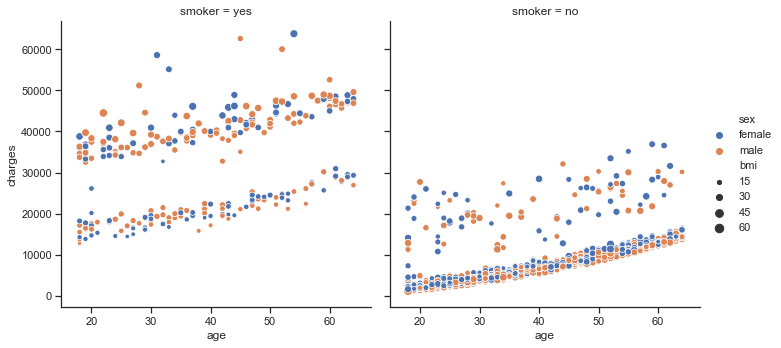

In [8]:
g3 = sns.relplot(x = 'age', y = 'charges', hue = 'sex', size = 'bmi', col = 'smoker', data = data)
#can observe some relationship between increase in bmi and insurance price which makes sense
#so bmi could explain the gap we see

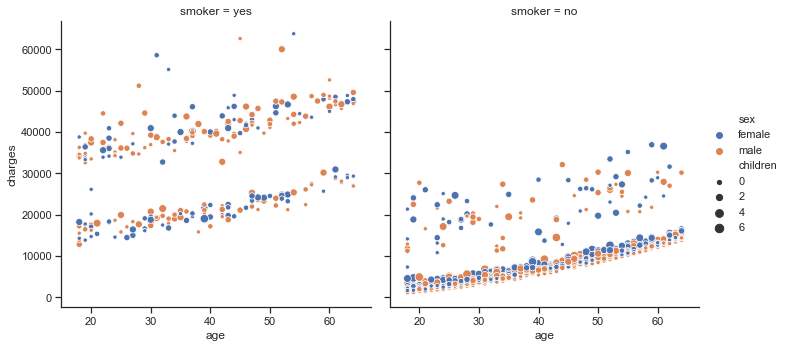

In [9]:
g4 = sns.relplot(x = 'age', y = 'charges', hue = 'sex', size = 'children', col = 'smoker', data = data)
#no real relationship children - higher charges visually observed

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

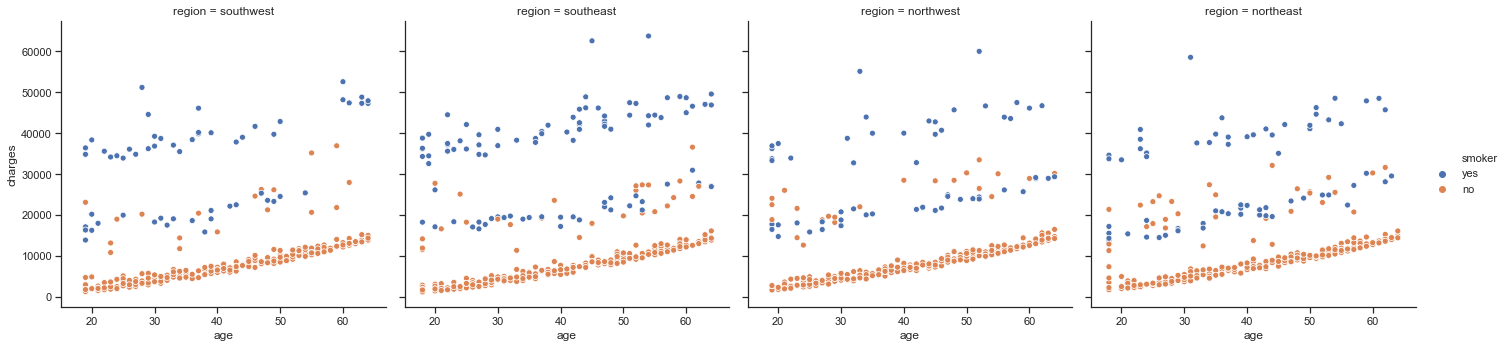

In [10]:
#charge per region given smoker
g5 = sns.relplot(x = 'age', y= 'charges', hue = 'smoker', col= 'region', data = data)
data['region'].value_counts()

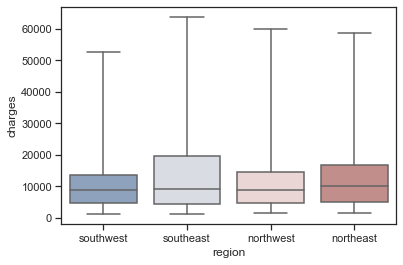

In [11]:
#boxplot for charges price in different regions
g5 = sns.boxplot(x = 'region', y = 'charges', data = data, whis = [0, 100], palette = 'vlag')

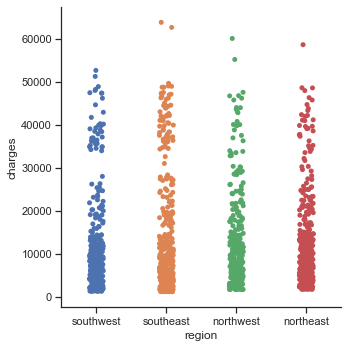

In [12]:
g6 = sns.catplot(x = 'region', y = 'charges', data = data) #distribution data point per region 

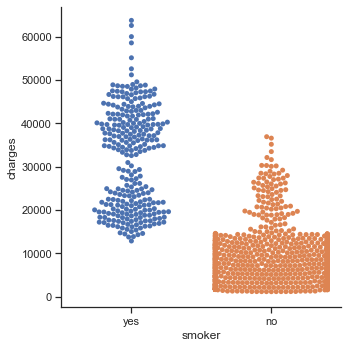

In [13]:
g7 = sns.catplot(x = 'smoker', y = 'charges', kind = 'swarm', data = data) 
#swarm plot to visualize better density of each category

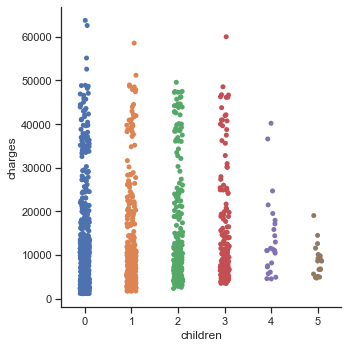

In [14]:
g8 = sns.catplot(x = 'children', y = 'charges', data = data)
#charges given nb of children: can see slight positive correlation children / charges 

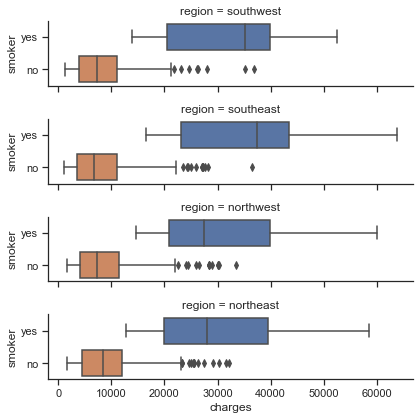

In [15]:
g9 = sns.catplot(x = 'charges', y = 'smoker', row = 'region', kind = 'box', orient = 'h', height = 1.5, aspect = 4, data = data)
#distribution of the price (charges) per region given smoker

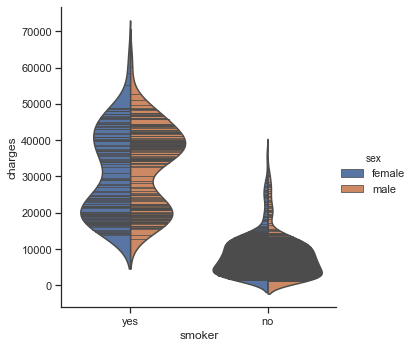

In [16]:
g11 = sns.catplot(x = 'smoker', y = 'charges', hue = 'sex', kind = 'violin', inner = 'stick', split = True, data = data)
#men smokers are more charged than women smokers

Create the regression algorithm via XGB Regressor

In [17]:
data.isnull().sum() #0
data.isna().sum() #0

#Separate dependent and idnependent variable
X = data.drop(['charges'], axis = 1)
y = data['charges']

In [18]:
#column transformer for mixed types
#doc: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score

In [19]:
X.dtypes

num_data = list(X.select_dtypes(exclude = 'object'))


num_transformer = Pipeline(steps = [('missing', SimpleImputer(strategy = 'median')),
                                    ('scaler', StandardScaler())])


#cat_data = X[['sex', 'smoker', 'region']] #no valid specification of the columns
cat_data = list(X.columns[X.dtypes == 'object'])
cat_transformer = Pipeline(steps = [('Replace missing cat', SimpleImputer(strategy = 'constant'))
        ,('categorical encoding', OneHotEncoder(handle_unknown = 'ignore'))])

preprocessor = ColumnTransformer(transformers = [('num', num_transformer, num_data), 
                                                 ('cat', cat_transformer, cat_data)])

#append regressor to pipeline
full_pipe = Pipeline(steps = [('preprocessor', preprocessor), ('regressor', XGBRegressor())])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [21]:
full_pipe.fit(X_train, y_train)
y_pred = full_pipe.predict(X_test)

[18:45:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [22]:
#metrics
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)

4323.986506839092
